In [ ]:
#Analysis Model(JH)
!pip install rembg==1.0.10

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 94 kB 3.0 MB/s 
     |████████████████████████████████| 5.9 MB 47.4 MB/s 
     |████████████████████████████████| 2.2 MB 53.4 MB/s 
     |████████████████████████████████| 12.5 MB 50.9 MB/s 
     |████████████████████████████████| 61 kB 483 kB/s 
     |████████████████████████████████| 748.8 MB 17 kB/s 
     |████████████████████████████████| 14.5 MB 43.2 MB/s 
     |████████████████████████████████| 58 kB 5.9 MB/s 
     |████████████████████████████████| 68 kB 6.8 MB/s 
  Created wheel for rembg: filename=rembg-1.0.10-py3-none-any.whl size=10916 sha256=50dead850003a7f82d491c443e853e91f60edcb5053547b583839fa617dff1fc
  Stored in directory: /root/.cache/pip/wheels/94/46/2c/0809f1587a2584b0ff940bce961fc7b40993fab72466c82ca8
Successfully built rembg
  Attempting uninstall: pillow
    Found existing installation: Pillow 7.1.2


In [ ]:
!pip install easyocr

     |████████████████████████████████| 70.8 MB 12.8 MB/s 
     |████████████████████████████████| 47.6 MB 70 kB/s 


In [ ]:
%cd /content
!git clone https://github.com/ultralytics/yolov5.git

/content
fatal: destination path 'yolov5' already exists and is not an empty directory.


In [ ]:
%cd /content/yolov5/
!pip install -r requirements.txt

/content/yolov5
     |████████████████████████████████| 596 kB 15.3 MB/s 
     |████████████████████████████████| 750.6 MB 11 kB/s 
     |████████████████████████████████| 21.0 MB 40.7 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.6.0
    Uninstalling torch-1.6.0:
      Successfully uninstalled torch-1.6.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.7.0
    Uninstalling torchvision-0.7.0:
      Successfully uninstalled torchvision-0.7.0
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
rembg 1.0.10 requires torch==1.6.0, but you have torch 1.11.0 which is incompatible.
rembg 1.0.10 requires torchvision==0.7.0, but you have torchvision 0.12.0 which 

In [ ]:
from glob import glob
from PIL import Image
from rembg.bg import remove
from IPython.display import Image
from sklearn.cluster import KMeans
from collections import OrderedDict
from google.colab.patches import cv2_imshow
import cv2
import os
import easyocr
import easydict
import argparse
import numpy as np
import matplotlib.pyplot as plt

result = []

def yoloExe(img):
    # %cd /content/yolov5/
    %cd /content/yolov5/
    img_list = glob(img)

    val_img_path = img_list[0]

    # weights_path = '/content/pill_yolo.pt'
    weights_path = '/content/drive/MyDrive/Colab/pill_yolo.pt'

    !python detect.py --weights "{weights_path}" --img 416 --conf 0.5 --source "{val_img_path}" --line-thickness 1 --save-crop

    detect_img_path = img
    Image(os.path.join(detect_img_path, os.path.basename(val_img_path)))

def setLabel(img, pts, label): #비율 계산에 사용되는 레이블 함수
    (x, y, w, h) = cv2.boundingRect(pts)
    pt1 = (x, y)
    pt2 = (x + w, y + h)
    cv2.rectangle(img, pt1, pt2, (0, 255, 0), 2)
    cv2.putText(img, label, (pt1[0], pt1[1]-3), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255))

def rmBg(path):
    input_path = path
    output_path = 'rmbg.jpg'

    with open(input_path, 'rb') as i:
        with open(output_path, 'wb') as o:
            input = i.read()
            output = remove(input)
            o.write(output)
    return '/content/rmbg.jpg'

def binary(path):
    img = cv2.imread(path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, dst = cv2.threshold (gray, 155, 255, cv2.THRESH_BINARY)
    cv2.imwrite("/content/binary.jpg", dst)

    img = cv2.imread("/content/binary.jpg")
    k = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    # 침식 연산 적용 ---②
    dilate = cv2.dilate(img, k)

    #cv2_imshow(erosion)
    cv2.imwrite("/content/dilate.jpg", dilate)
    return '/content/dilate.jpg'

def reverse(path): #이진화된 이미지 반전시키는 함수
    img = cv2.imread(path)
    out = img.copy()
    out = 255 - out
    cv2.imwrite("/content/pill.jpg", out)
    return '/content/pill.jpg'

def cont(path): #원, 타원, 장방형의 각형을 알려주는 함수
    img = cv2.imread(path)
    img2 = img.copy()
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    res, thr = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(thr, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    cnt = contours[0]
    cv2.drawContours(img, [cnt], -1, (255, 255, 0), 2)

    epsilon2 =  0.005 * cv2.arcLength(cnt, True)
    approx2 = cv2.approxPolyDP(cnt, epsilon2, True)
    cv2.drawContours(img2, [approx2], -1, (0, 255, 0), 3)

    print("[Case1.제형] n각형 분석 : "+str(len(approx2))+"각형")
    detect(path)
    #print(len(approx2))
    if len(approx2) == 16: #16각형이면 detect함수 실행
        detect(path)
    else: #16각형이 아니면 장방형
        #print("장방형")
        result.append("장방형")

def detect(path): #가로세로 비율을 통해 원인지 타원인지 분류하는 함수
    src = cv2.imread(reverse(path))
    dst = src.copy()

    gray = cv2.cvtColor(src, cv2.COLOR_RGB2GRAY)
    ret, binary = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY_INV)

    contours, hierarchy = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_NONE)
    for i in contours:
        M = cv2.moments(i)
        cX = int(M['m10'] / M['m00'])
        cY = int(M['m01'] / M['m00'])
        
        cv2.circle(dst, (cX, cY), 3, (0, 0, 255), -1)
        cv2.drawContours(dst, [i], 0, (0, 0, 255), 2)

        setLabel(dst, i, '')
        (x, y, w, h) = cv2.boundingRect(i)
        
    if (h/w) > 0.95 and (h/w) < 1.05: #비율이 0.95와 1.05사이이면 원 출력
        #print("원형")
        result.append("원형")
        print("[Case2.비율] 비율 분석(세로/가로 비율) : "+str(h/w))
    else: #그렇지 않으면 타원 출력
        #print("타원형")
        result.append("타원형")
        print("[Case2.비율] 비율 분석(세로/가로 비율) : "+str(h/w))

def centroid_histogram(clt):
	# grab the number of different clusters and create a histogram
	# based on the number of pixels assigned to each cluster
	numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
	(hist, _) = np.histogram(clt.labels_, bins = numLabels)

	# normalize the histogram, such that it sums to one
	hist = hist.astype("float")
	hist /= hist.sum()

	# return the histogram
	return hist

def plot_colors(hist, centroids):
	# initialize the bar chart representing the relative frequency
	# of each of the colors
	bar = np.zeros((50, 300, 3), dtype = "uint8")
	startX = 0

	# loop over the percentage of each cluster and the color of
	# each cluster
	for (percent, color) in zip(hist, centroids):
		# plot the relative percentage of each cluster
		endX = startX + (percent * 300)
		cv2.rectangle(bar, (int(startX), 0), (int(endX), 50),
			color.astype("uint8").tolist(), -1)
		startX = endX
	
	# return the bar chart
	return bar

def second_largest_number(arr):
    unique_nums = set(arr)
    sorted_nums = sorted(unique_nums, reverse=True)
    return sorted_nums[1]

'그레이 스케일'
def mtjin_bgr2gray(bgr_img):
    # BGR 색상값
    b = bgr_img[:, :, 0]
    g = bgr_img[:, :, 1]
    r = bgr_img[:, :, 2]
    result = ((0.299 * r) + (0.587 * g) + (0.114 * b))
    # imshow 는 CV_8UC3 이나 CV_8UC1 형식을 위한 함수이므로 타입변환
    return result.astype(np.uint8)

'히스토그램 평활화'
def histogram_equalization(img):
  src = cv2.imread(img, cv2.IMREAD_GRAYSCALE)
  dst = cv2.equalizeHist(src)
  #cv2_imshow(dst)
  cv2.imwrite("histogram_eq.jpg", dst)

'노이즈 제거(OCR)'
def rm_noise(img):
  src = cv2.imread(img, cv2.IMREAD_COLOR)
  denoised_img = cv2.fastNlMeansDenoisingColored(src, None, 15, 15, 5, 10)
  #cv2_imshow(src)
  #cv2_imshow(denoised_img)
  cv2.imwrite("denoise.jpg", denoised_img)

'노이즈 제거(제형)'
def rm_noise2(img):
  src = cv2.imread(img, cv2.IMREAD_COLOR)
  denoised_img = cv2.fastNlMeansDenoisingColored(src, None, 15, 15, 5, 10)
  #cv2_imshow(src)
  #cv2_imshow(denoised_img)
  cv2.imwrite("denoise2.jpg", denoised_img)

'OCR'
def ocr(img):
  reader = easyocr.Reader(['ko', 'en'])
  output = reader.readtext(img, detail = 0)
  joined_str = "".join(output) 
  #print(joined_str)
  result.append(joined_str)
  print("[Case4.OCR] OCR 분석 결과 : "+joined_str)

def main(): #메인함수
    #제형 구하는 부분
    yoloExe("/content/drive/MyDrive/Colab/pill_rect.jpg") #YOLO 함수 호출 #이미지 경로에 사용자가 촬영, 선택한 이미지 경로 넣어야함
    %cd /content
    # rm_path = rmBg('/content/yolov5/runs/detect/exp/crops/pill/원형알약.jpg') #배경제거 함수 호출
    rm_path = rmBg('/content/yolov5/runs/detect/exp8/crops/pill/pill_rect.jpg') #배경제거 함수 호출
    first_path = binary(rm_path)
    second_path = binary(first_path)
    third_path = binary(second_path)
    fourth_path = binary(third_path)
    cont(fourth_path)
    #reverse('/content/binary.png')

    #색상 구하는 부분
    args = easydict.EasyDict({
        "image": True,
        "clusters": 3
    })

    image = cv2.imread(rm_path) #이미지 경로에 rm_path 넣어야함
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    #plt.figure()
    #plt.axis("off")
    #plt.imshow(image)

    # reshape the image to be a list of pixels
    image = image.reshape((image.shape[0] * image.shape[1], 3))

    # cluster the pixel intensities
    clt = KMeans(n_clusters = args["clusters"])
    clt.fit(image)

    # build a histogram of clusters and then create a figure
    # representing the number of pixels labeled to each color
    hist = centroid_histogram(clt)
    bar = plot_colors(hist, clt.cluster_centers_)

    # show our color bart
    #plt.figure()
    #plt.axis("off")
    #plt.imshow(bar)
    #plt.show()

    temp = clt.cluster_centers_
    color_value = temp.astype("uint8").tolist() #세 컬러의 rgb값
    second_num = second_largest_number(hist) #히스토그램에서 두 번째로 큰 값(두 번째 색)

    for i in range(3): #두 번째로 큰 값의 인덱스를 구함
      if (second_num == hist[i]):
        color_idx = i

    #print(color_value[color_idx])

    if (color_value[color_idx][0] > 190) and (color_value[color_idx][1] > 190) and (color_value[color_idx][2] > 190):
      #print("하양")
      result.append("하양")
    elif (color_value[color_idx][0] < 50) and (color_value[color_idx][1] < 50) and (color_value[color_idx][2] < 50):
      #print("검정")
      result.append("검정")
    elif (abs(color_value[color_idx][0] - color_value[color_idx][1]) < 20) and (abs(color_value[color_idx][0] - color_value[color_idx][1]) < abs(color_value[color_idx][1] - color_value[color_idx][2])):
      #print("노랑")
      result.append("노랑")
    elif (abs(color_value[color_idx][0] - color_value[color_idx][2]) < 20):
      #print("분홍")
      result.append("분홍")
    elif (color_value[color_idx][0] > color_value[color_idx][1]) and (color_value[color_idx][0] > color_value[color_idx][2]):
      #print("빨강 계열")
      result.append("빨강 계열")
    elif (color_value[color_idx][1] > color_value[color_idx][0]) and (color_value[color_idx][1] > color_value[color_idx][2]):
      #print("녹색 계열")
      result.append("녹색 계열")
    elif (color_value[color_idx][2] > color_value[color_idx][0]) and (color_value[color_idx][2] > color_value[color_idx][1]):
      #print("파랑 계열")
      result.append("파랑 계열")

    print("[Case3.색상] 색상 분석(R,G,B)")  
    print("[Case3-1.색상] 색상 분석(빨간색, R) : "+str(color_value[color_idx][0]))
    print("[Case3-2.색상] 색상 분석(초록색, G) : "+str(color_value[color_idx][1]))    
    print("[Case3-3.색상] 색상 분석(파란색, B) : "+str(color_value[color_idx][2]))

    #텍스트 구하는 부분
    input_img = cv2.imread(rm_path, cv2.IMREAD_COLOR) #이미지 경로 변경 #이미지 경로에 rm_path 넣어야함
    bgr_img = mtjin_bgr2gray(input_img)
    #cv2_imshow(bgr_img)
    cv2.imwrite("gray.jpg", bgr_img)
    histogram_equalization("/content/gray.jpg")
    rm_noise("/content/histogram_eq.jpg")
    rm_noise("/content/denoise.jpg")
    rm_noise("/content/denoise.jpg")
    rm_noise("/content/denoise.jpg")
    ocr("/content/denoise.jpg")

    print("[Case5.최종 분석결과] : "+str(result))

if __name__ == "__main__":
	  main()

/content/yolov5
detect: weights=['/content/drive/MyDrive/Colab/pill_yolo.pt'], source=/content/drive/MyDrive/Colab/pill_rect.jpg, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=True, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=1, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-186-g3356f26 Python-3.7.13 torch-1.11.0+cu102 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7012822 parameters, 0 gradients
image 1/1 /content/drive/MyDrive/Colab/pill_rect.jpg: 256x416 2 pills, Done. (0.113s)
Speed: 0.7ms pre-process, 113.2ms inference, 1.1ms NMS per image at shape (1, 3, 416, 416)
Results saved to runs/detect/exp47
/content


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


[Case1.제형] n각형 분석 : 14각형
[Case2.비율] 비율 분석(세로/가로 비율) : 0.9848484848484849
[Case3.색상] 색상 분석(R,G,B)
[Case3-1.색상] 색상 분석(빨간색, R) : 188
[Case3-2.색상] 색상 분석(초록색, G) : 168
[Case3-3.색상] 색상 분석(파란색, B) : 155


CUDA not available - defaulting to CPU. Note: This module is much faster with a GPU.


[Case4.OCR] OCR 분석 결과 : PIIU471
[Case5.최종 분석결과] : ['원형', '장방형', '빨강 계열', 'PIIU471']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Google Drive 연동(마운트)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


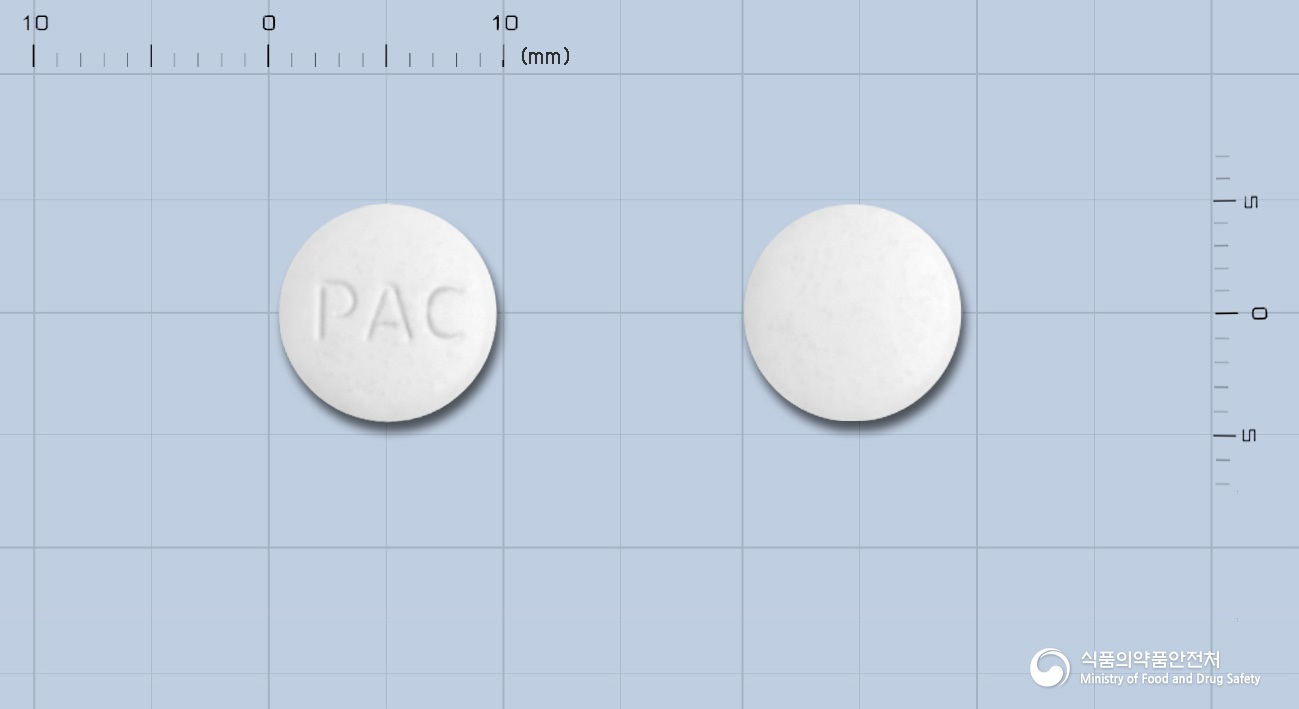

In [ ]:
# Google Drive에 업로드된 이미지 호출 및 출력
from IPython.display import Image
Image('/content/gdrive/MyDrive/Colab/pill.jpg')